# Secure your Azure SQL Database
Secure your Azure SQL Database to keep your data secure and diagnose potential security concerns as they happen.

In this module, you will:

1. Control network access to your Azure SQL Database using firewall rules
2. Control user access to your Azure SQL Database using authentication and authorization
3. Protect your data in transit and at rest
4. Audit and monitor your Azure SQL Database for access violations

## Exercise - Secure a database
First, to show how to secure your database, set up the following resources
- A Linux VM named appServer. This server will act as the application server that users would be connecting to, and will need to connect to the database. We'll install sqlcmd on the VM to simulate an application running on appServer making connections to the database.
- An Azure SQL Database logical server. This logical server is needed to host one or more databases.
- A database on our logical server called marketplaceDb. We'll create it using the AdventureWorksLT demo database so we have some tables and data to work with. This will include some sensitive data, such as email addresses and phone numbers that we'll want to make sure are properly secured.

### Create Azure SQL DB

Step 1: In Bash set up variables 

Set an admin login and password for your database

`export ADMINLOGIN='[ServerAdmin]'
export PASSWORD='[password]'`

Set the logical SQL server name. We'll add a random string as it needs to be globally unique.

`export SERVERNAME=server$RANDOM
export RESOURCEGROUP=learn-070869d0-8594-4673-8283-02d536c2e17d`

Set the location, we'll pull the location from our resource group. REMEMBER THIS

`export LOCATION=$(az group show --name $RESOURCEGROUP | jq -r '.location')`

Step 2: Create Azure SQL DB logical server

`az sql server create \
    --name $SERVERNAME \
    --resource-group $RESOURCEGROUP \
    --location $LOCATION \
    --admin-user $ADMINLOGIN \
    --admin-password "$PASSWORD"`
   

Step 3: Create the `marketplaceDb` on the logical server just created, use *AdventureWorksLT* databse as template

`az sql db create --resource-group $RESOURCEGROUP \
    --server $SERVERNAME \
    --name marketplaceDb \
    --sample-name AdventureWorksLT \
    --service-objective Basic`

Step 4: Get connection string for DB

`az sql db show-connection-string --client sqlcmd --name marketplaceDb --server $SERVERNAME | jq -r`

Note: I don't understand the | jq -r, I know | is piping to JSON parsing, however the only difference in output is that this bit removes quotations on same output

### Create and configure a Linux virtual machine
Step 1: Create VM

`az vm create \
  --resource-group $RESOURCEGROUP \
  --name appServer \
  --image UbuntuLTS \
  --size Standard_DS2_v2 \
  --generate-ssh-keys`
  

Step 2: Connect to public IP address (output of the VM creation)

`ssh nnn.nnn.nnn.nn`

Step 3: install mssql-tools on Linux VM to connect to database through `sqlcmd`

`echo 'export PATH="$PATH:/opt/mssql-tools/bin"' >> ~/.bash_profile
echo 'export PATH="$PATH:/opt/mssql-tools/bin"' >> ~/.bashrc
source ~/.bashrc
curl https://packages.microsoft.com/keys/microsoft.asc | sudo apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list | sudo tee /etc/apt/sources.list.d/msprod.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get install -y mssql-tools unixodbc-dev`

I tried typing this all in myself, nothing here worked because I forgot to SSH. Second time I just pasted it all in

## Ways to control access to SQL Database
1. Firewall rules- initially all public access to DB is blocked by the SQL Db firewall. Rules are configured at teh server and/or database level. Depending on the level, rules you can apply will be as follows:
  - Server-level Firewall rules - can all be created and manipulated through portal, PowerShell, CLI, and through Transact-SQL (T-SQL)
    - Allow Access to Azure Services
    
      <img src="https://docs.microsoft.com/en-us/learn/modules/secure-your-azure-sql-database/media/2-allow-azure-services.png">
    - IP address rules
    
      <img src="https://docs.microsoft.com/en-us/learn/modules/secure-your-azure-sql-database/media/2-server-ip-rule-1.png">
    - Virtual network rules - limit access to subnets, VNet Address spaces private so you can eliminate exposure to public IP addresses
    
      <img src="https://docs.microsoft.com/en-us/learn/modules/secure-your-azure-sql-database/media/2-vnet-rule.png">
  - Database-level firewall rules - When replicating a database to another server, the database-level rules will be replicated, since they are stored in the database itself. Downside is only IP address rules. Can only be created and manipulated through T-SQL
    - IP address rules
    
      <img src="https://docs.microsoft.com/en-us/learn/modules/secure-your-azure-sql-database/media/2-db-ip-rule-1.png">

### Restricting network access in practice
Whenever possible, as a best practice, use database-level IP firewall rules to enhance security and to make your database more portable. Use server-level IP firewall rules for administrators and when you ahve several databases with the same access requirements and you don't want to spend time configuring each database individually.

Some things I did in this exercise:
- Use the server-level allow access to Azure services rule through portal - but allows access from any Azure resource, even outside our subscription
- used T-SQL command `EXECUTE` to set database firewall rule in the `sqlcmd` prompt, we then disable Access to Azure Services but we can still connect because we allowed access to the IP address of our SQL server.
- Use a server level IP address rule to allow connectivity despite having all Access to Azure Services turned off still and the database rule still turned off.
- Used Server-level virtual network rule (added) to allow anyserver in appServerSubnet ip range

What we've done here effectively removes any public access to the SQL server, and only permits access from the specific subnet in the Azure VNet we defined. If we were to add additional app servers in that subnet, no additional configuration would be necessary, as any server in that subnet would have the ability to connect to the SQL server. This limits our exposure to services outside of our scope of control, and eases administration if we were to add additional servers. This is an effective method of securing network access to an Azure SQL Database.

## Authentication
SQL Database supports two types of authentication
1. SQL Authentication - in master DB or in sub DB
2. Azure Active Directory Authentication - Uses identities managed by Azure Active Directory. Use Azure AD authentication (integrated security) whenever possible. Must create server admin called the "Azure AD admin"

## Authorization
You can give permission to user accoutn directly or to database role membership

## In practice
Your application shoudl use a dedicated account to authenticate. This way you can limit permissions granted to the application and reduce the risks of malicious activity in case the application code is vulnerable to a SQL injection attack.

## Exercise


### Create a database user
Set up a user and grant access to database. Using SQL authentication but process would be essentially same if using Azure AD
`CREATE USER ApplicationUser WITH PASSWORD = 'YourStrongPassword1';
GO`

### Grant permissions to a user
make user a member of `db_datareader` and `db_datawriter` roles

`ALTER ROLE db_datareader ADD MEMBER ApplicationUser;
ALTER ROLE db_datawriter ADD MEMBER ApplicationUser;
GO`

Then to Deny SELECT access

`DENY SELECT ON SalesLT.Address TO ApplicationUser;
GO`

Then we log on as user to test out. Didn't work for me - I'll try this again. Did it again and it worked!

This lab is annoying as I'm not given a ton of time with the sandbox.

## Exercise - Secure your data in transit, at rest and on display
 By using TLS encryption, you can ensure that anyone who may have intercepted the traffic between the app server and database would not be able to read the data. 

Azure Encrypts data
- In transit: Azure SQL Database enforces Transport Layer Security (TLS) encryption at all times for all connections, which ensures all data is encrypted "in transit" between the database and the client.TLS encryption is a standard of securing traffic over he internet, and in this case ensures your network traffic to and from your Azure SQL database is secure by default.
- At Rest: Azure SQL Database protects your data at rest using transparent data encryption (TDE). TDE performs real-time encryption and decryption of the database, associated backups, and transaction log files at rest without requiring changes to the application. Data is decrypted when loaded into memory and encrypted when put into storage. TDE Enabled by default for all newly deployed Azure SQL Databases.
- Dynamic Data bmasking - ewe can limit the data that is displayed to the user. Policy-based security feature that hides the sensitive data in the result set of a query over designated database fields, while the data in the database is not changed. DB admin can control this. You can create your own mask, or use a standard mask such as
  - Default value
  - Credit card value - last 4 digits
  - Email - hides domain name and all but first character of email account name
  - Number - which specifies a random number between range of values
  - Custom string, number of characters exposed at start of string.

In the masking exercise, we added the custom string and email masks with the portal appled to the SalesLT.Customer table. Then `SELECT`ed from it as the user and it worked!

#### Exercise - Monitor your database
Azure SQL Database Auditing - Audit logs written to Appedn blobs in Azure Blob storage account designated. Use azure portal to view the logs, or send them to Log Analytics or Event Hub for further processing and analysis.

Best practice - avoid enabling both server blob auditing and database blob auditing together unless:
- you want to use a different storage account or retention period for a specific databse
- you want to audit event types or categories for a specific database that differs from the rest of the databases on the server. For example, you might have table inserts that need to be audited but only for a specific database.


`Notes:` In the exercise I generated server audit logs for when `ApplicationUser` queried the database. The logs were viewable in the `marketDb` database with `ApplicationUser` as a Principal, and more details available. Told me whether it succeeded or failed, application name, client IP etc

### Advanced data Security for Azure SQL Database
Advanced SQL security capabilities, including data discovery & classification, vulnerability assessment, and Advanced Threat protection.



`Notes:` Setup advanced data security on the server level, then visited the Advanced Data Security in the MarkeplaceDb, checked out Data Discovery & classification and did a scan for the Vulnerability Assessment! this picture cambe up

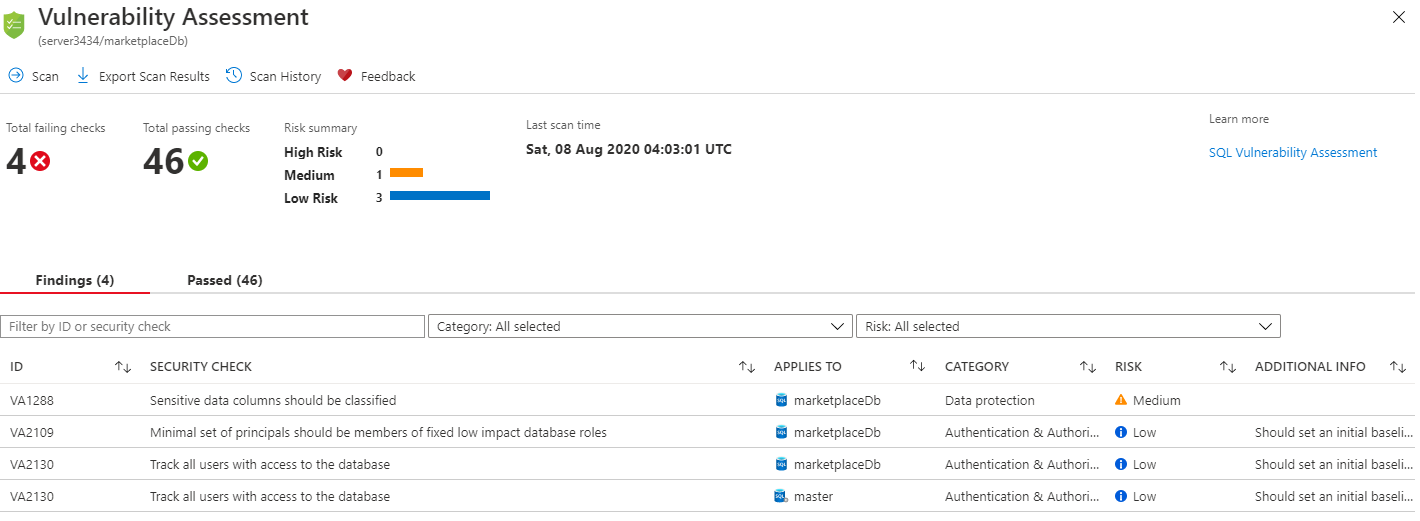

Knowledge check

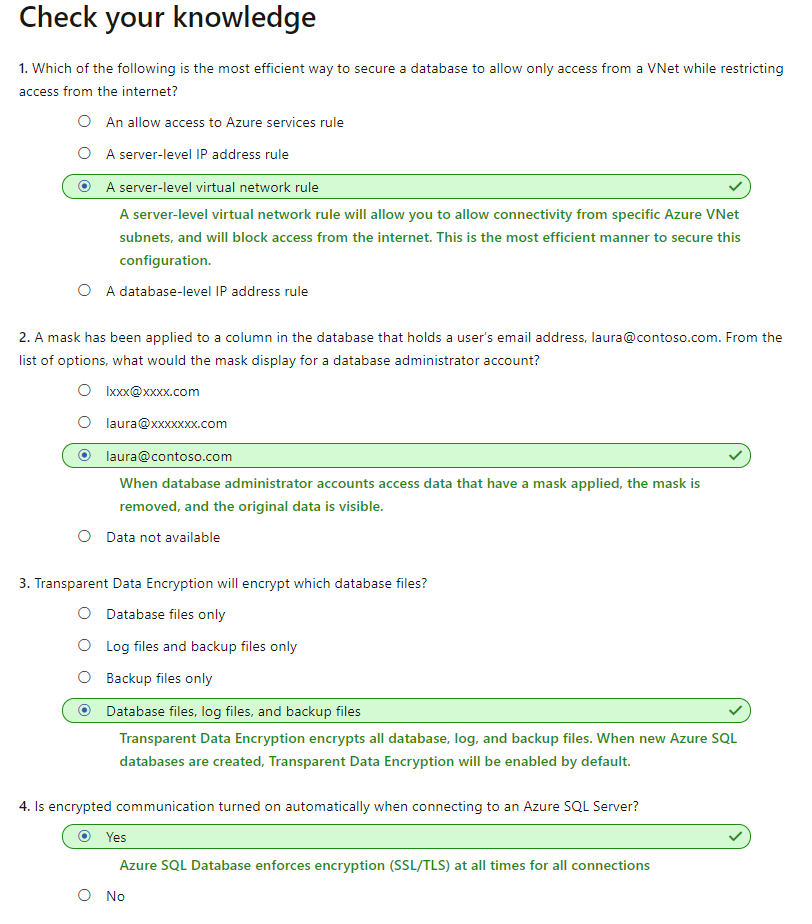

Further reading
To learn more about the concepts we've covered in this module, check out these other resources.
- https://docs.microsoft.com/en-us/azure/sql-database/sql-database-firewall-configure Manage IP Firewall rules for Azure SQL Server
- https://docs.microsoft.com/en-us/azure/sql-database/sql-database-advanced-data-security Manage Advanced Data Security settings for a SQL DB